## Example -- Taylor 2023

Example of using `optiwindnet` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [1]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MILP, ModelOptions, load_repository

In [2]:
# set Matplotlib option to generate inline SVG
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'

### Solvers

Using a MILP solver can produce better solutions. This notebook uses COIN-OR CBC but examples for other solvers can be found in the *MILP* notebooks.

There are some differences in solver parameters even for the ones supported through pyomo.

Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

### Load input data

In [3]:
locations = load_repository()

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [4]:
wfn = WindFarmNetwork(L=locations.taylor_2023, cables=8)

 Note: To view SVG cell outputs, trust this notebook first.

<Axes: >

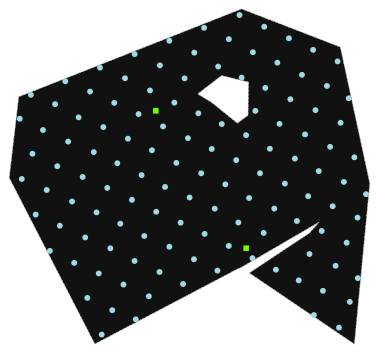

In [5]:
wfn.plot_location()

<Axes: >

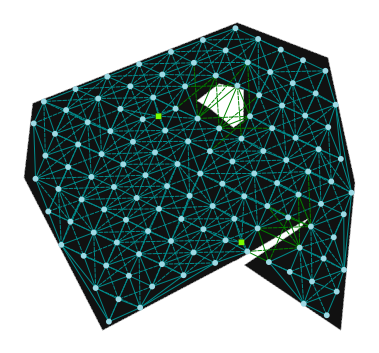

In [6]:
wfn.plot_available_links()

<Axes: >

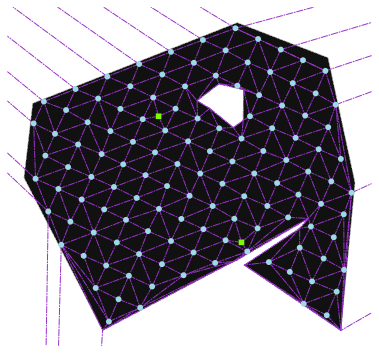

In [7]:
wfn.plot_navigation_mesh()

There are two options for generating an initial solution to warm-start the MILP solver:
- heuristic `EW_presolver()`
- meta-heuristic `hgs_multiroot()`

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

In this example, we use EW_presolver for warmstarting the model. HGS_multiroot() could be used alternatively. After running `wfn.optimize(router=router_warmstart)`, the solution is stored in `wfn`object and next time we run `wfn.optimize()`, the stored solution can be used as warmstart (If the router is capable of warmstarting).

In [8]:
router_warmstart = Heuristic(solver='Esau_Williams')
res_warmstart= wfn.optimize(router=router_warmstart)

### Visualizing the warm-start solution

This section is unecessary in production.

S which contains selected links is used for warmstart (not final graph which is stored in G). S can be visualized using wfn.plot_selected_links()

<Axes: >

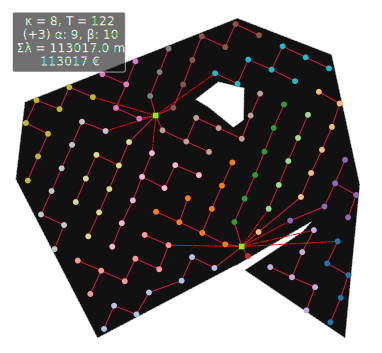

In [9]:
wfn.plot_selected_links()

### Create MILP model and optimize it using COIN-OR Branch and Cut (CBC)

In [10]:
solver_options=dict( # these are in addition to the default solver.options
        # if repeatable results are desired, set the seed
        RandomCbcSeed=1234567,
        # CBC works better if the number threads is set to the number of physical cores
        threads=8,
    )


model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router = MILP(solver_name='cbc', time_limit=300, mip_gap=0.005, solver_options=solver_options, model_options=model_options)

the parameters below and more can be experimented with

http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf

In [11]:
router.default_options

{'threads': 8,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

Run optimizatin with MILP router

In [12]:
res = wfn.optimize(router=router, verbose=True)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - C:\my_program_files\cbc\bin\cbc.exe -threads 8 -timeMode elapsed -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -Rens on -Rins on -pivotAndComplement off -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -RandomCbcSeed 1234567 -seconds 300 -ratioGap 0.005 -printingOptions all -import C:\Users\amia\AppData\Local\Temp\tmpknb0iktd.pyomo.lp -stat=1 -solve -solu C:\Users\amia\AppData\Local\Temp\tmpknb0iktd.pyomo.soln (default strategy 1)
threads was changed from 0 to 8
Option for timeMode changed from cpu to elapsed
Option for nodeStrategy changed from fewest to downfewest
Option for Dins changed from off to on
Option for VndVariableNeighborhoodSearch changed from off to on
Option for Rens changed from off to on
Opti

Terse link of the final layout is returned as output of `wfn.optimize()`. If not assigned to a variable (e.g. res), it can be easily accessed via `wfn.terse_links()`.

In [13]:
print(res)

[  6   0   1  10  11   4   5  14   7  17   9  19  20  12  13  16  24  26
  17  -2  29  14  31  32  25  34  27  28  -2  -2  -2  42  33  43  35  36
  37  -2  -2  -2  -2  52  53  44  45  55  56  46  38  39  49  40  64  54
  66  67  68  56  48  49  59  51  61  62  65  77  79  -1  81  57  69  58
  71  72  73  63  75  78  89  80  -1  -1  -1  82  83  84  85  74  75  90
  -1  -1  -1  -1  93  94  95  86  97 100  91  92  -1 102 105  96 105  98
 100 101 111 103 111 112 106 109 115 121 119 113 116 120]


The selected links (from the available links without any detour) can be visualized via `wfn.plot_selected_links()`.

<Axes: >

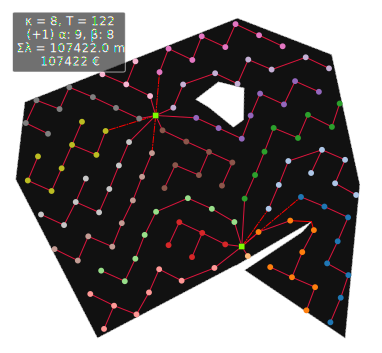

In [14]:
wfn.plot_selected_links()

### Trace routes from solution topology
The final layout (G), can be visualized via `wfn.plot()`.

<Axes: >

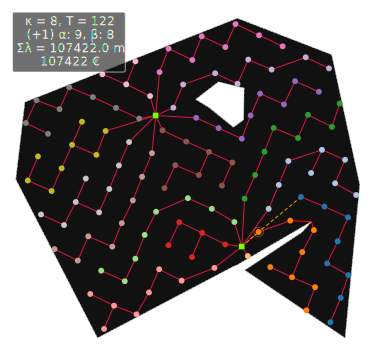

In [15]:
wfn.plot()